In [1]:
import numpy as np 
import pandas as pd 
import os

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, MaxPooling2D,Conv2D,Input,UpSampling2D, Flatten, Reshape
from tensorflow.keras.layers import BatchNormalization, Dropout, Lambda, Conv2DTranspose, Layer, LeakyReLU
from tensorflow.keras.losses import binary_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1
import keras.backend as K
import tensorflow as tf
#from tensorflow.keras import metrics
from keras.models import Sequential
from sklearn.metrics import f1_score, classification_report
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from tqdm import tqdm
import random
# to ignore displaying warnings
import warnings
warnings.filterwarnings("ignore")

2022-08-28 17:28:41.535668: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-28 17:28:41.535700: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
import matplotlib.pyplot as plt
#import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [3]:
normal_path = "../../data/mimii-anomaly-detection/dataset_cnn/6db/normal"
abnormal_path = "../../data/mimii-anomaly-detection/dataset_cnn/6db/normal"

In [4]:
classes = {'normal':0,'abnormal':1}

In [5]:
def assign_label(img, anomaly):
    return anomaly

In [6]:
X = []
y = []

In [7]:
# Declare constants
IMAGE_HEIGHT = 217
IMAGE_WIDTH = 334

In [8]:
def make_data(anomaly, DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img, anomaly)
        path = os.path.join(DIR, img)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMAGE_WIDTH,IMAGE_HEIGHT))
        
        X.append(np.array(img))
        y.append(label)

In [9]:
make_data(classes.get('normal'), normal_path)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 1475/1475 [00:01<00:00, 750.37it/s]


In [10]:
len(X), len(y), np.unique(y, return_counts=True)

(1475, 1475, (array([0]), array([1475])))

In [11]:
make_data(classes.get('abnormal'), abnormal_path)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 1475/1475 [00:01<00:00, 750.56it/s]


In [12]:
len(X), len(y), np.unique(y, return_counts=True)

(2950, 2950, (array([0, 1]), array([1475, 1475])))

In [13]:
type(X), type(y)

(list, list)

In [14]:
def preprocess_images(images, y, normalize = True):
    X = []
    for i in tqdm(range(len(images))):
        img = img_to_array(images[i]).astype('float32')
        if normalize:
            img = img/255.0
        X.append(img)
    #Shuffle data
    dataset = list(zip(X, y))
    random.shuffle(dataset)

    X, y = zip(*dataset)
    return np.array(X), np.array(y)

In [15]:
normalize = True

X, y = preprocess_images(X, y, normalize=normalize)
print("Shape of X:", X.shape)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 2950/2950 [00:01<00:00, 1611.65it/s]


Shape of X: (2950, 217, 334, 3)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [17]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2065, 217, 334, 3), (2065,), (885, 217, 334, 3), (885,))

In [18]:
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True), 

((array([0, 1]), array([1019, 1046])), (array([0, 1]), array([456, 429])))

In [19]:
type(X_train[0]), type(y_train[0])

(numpy.ndarray, numpy.int64)

In [20]:
y_train[:5]

array([1, 0, 0, 1, 0])

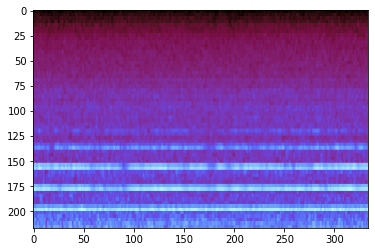

In [21]:
imgplot_0 = plt.imshow(X_train[0])

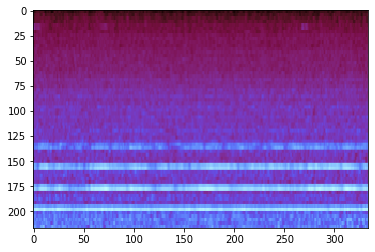

In [22]:
imgplot_1 = plt.imshow(X_train[1])

In [23]:
# Initialising the CNN
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Conv2D(32, (3, 3), input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3), activation = 'relu'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a third convolutional layer
classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a fourth convolutional layer
classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 64, activation = 'relu'))
classifier.add(Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

2022-08-28 17:30:53.066427: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-28 17:30:53.066453: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (iotg): /proc/driver/nvidia/version does not exist
2022-08-28 17:30:53.066819: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
# from keras.utils.vis_utils import plot_model
# from PIL import Image
# plot_model(classifier, to_file='models/cnn_model.png', show_shapes=True, show_layer_names=True)
# display(Image.open('models/cnn_model.png'))

In [25]:
history = classifier.fit(X_train, y_train,
                    batch_size=32,
                    epochs=8,
                    verbose=1)

Epoch 1/8
65/65 [==============================] - 40s 602ms/step - loss: 0.7004 - accuracy: 0.5012
Epoch 2/8
65/65 [==============================] - 38s 585ms/step - loss: 0.6932 - accuracy: 0.4862
Epoch 3/8
65/65 [==============================] - 38s 584ms/step - loss: 0.6933 - accuracy: 0.4814
Epoch 4/8
65/65 [==============================] - 38s 582ms/step - loss: 0.6931 - accuracy: 0.5065
Epoch 5/8
65/65 [==============================] - 38s 589ms/step - loss: 0.6931 - accuracy: 0.5065
Epoch 6/8
65/65 [==============================] - 38s 588ms/step - loss: 0.6931 - accuracy: 0.5065
Epoch 7/8
65/65 [==============================] - 39s 592ms/step - loss: 0.6931 - accuracy: 0.5065
Epoch 8/8
65/65 [==============================] - 38s 592ms/step - loss: 0.6931 - accuracy: 0.5065
